(67, 19)


KeyError: 'Character'

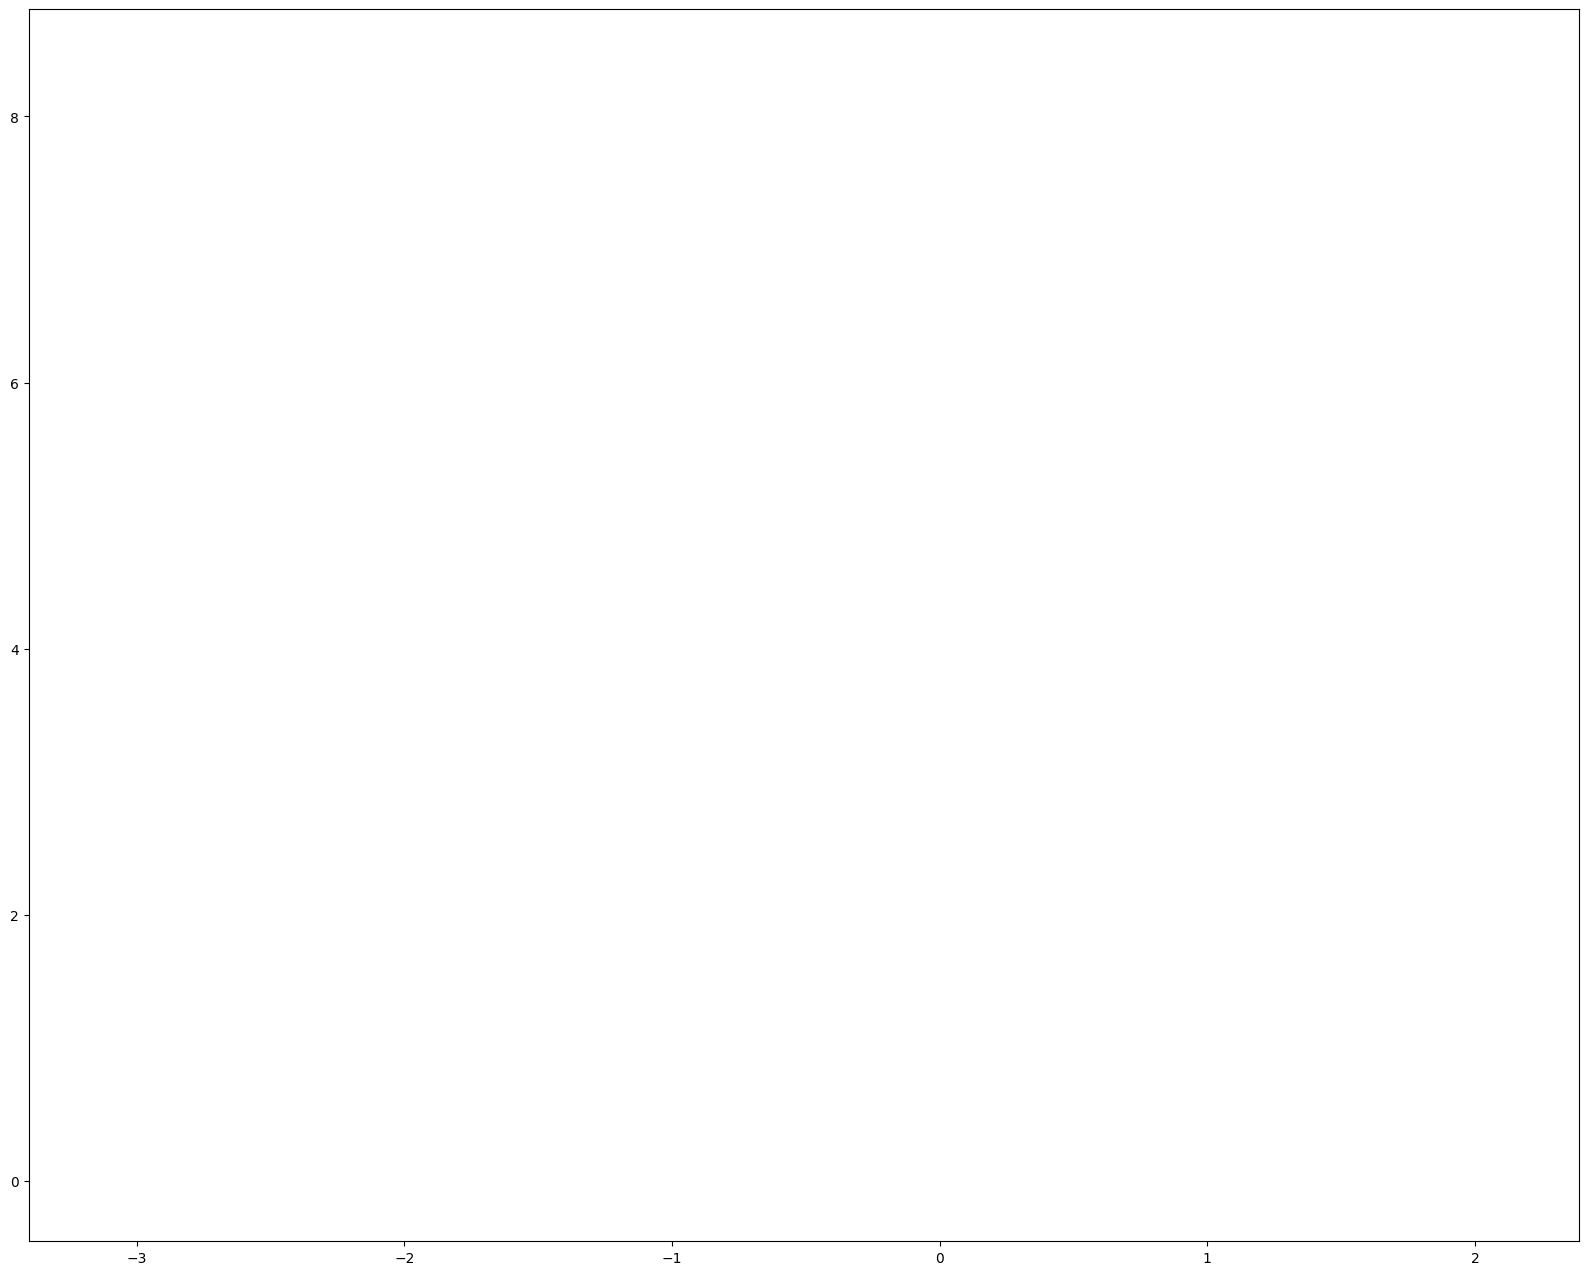

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import spacy
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to load and resize image
def get_image(path, zoom=0.4):
    return OffsetImage(plt.imread(path), zoom=zoom)

# Function to lemmatize text using spaCy
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Load the data
data = pd.read_csv('Results.csv')

# Extract character names and remove from main data
character_names = data.iloc[:, 0].tolist()
main_data = data.iloc[:, 1:]

# Identify numeric and text columns
numeric_columns = main_data.select_dtypes(include=[np.number]).columns
text_columns = main_data.select_dtypes(exclude=[np.number]).columns

# Preprocess numeric columns
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')
numeric_data = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(main_data[numeric_columns])), 
                            columns=numeric_columns)

print(main_data[text_columns].shape)

# Preprocess text columns using TfidfVectorizer and spaCy lemmatization
tfidf = TfidfVectorizer()  # You can adjust max_features as needed
text_data = main_data[text_columns].fillna('')
text_data_combined = text_data.apply(lambda x: ' '.join(x), axis=1)
lemmatized_text = text_data_combined.apply(lemmatize_text)
tfidf_matrix = tfidf.fit_transform(lemmatized_text)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Combine processed data
processed_data = pd.concat([numeric_data, tfidf_df], axis=1)

# Cluster the processed main data
kmeans = KMeans(n_clusters=8, random_state=42)
main_clusters = kmeans.fit_predict(processed_data)

# Save clustered data to a new file
clustered_data = processed_data.copy()
clustered_data['Cluster'] = main_clusters
clustered_data.to_csv('clustered_main_data.csv', index=False)

# Apply TSNE
tsne = TSNE(n_components=2)
tsne_2d = tsne.fit_transform(processed_data)
tsne_2d = pd.DataFrame(tsne_2d, columns=['x', 'y'])
tsne_2d['Character'] = character_names

tsne = TSNE(n_components=3)
tsne_result = tsne.fit_transform(processed_data)

# Combine TSNE results with character names
tsne_df = pd.DataFrame(tsne_result, columns=['x', 'y', 'z'])
tsne_df['Character'] = character_names
tsne_df.to_csv("data1.csv")

# Create a graph with images
plt.figure(figsize=(20, 16))
scatter = plt.scatter(tsne_2d['x'], tsne_2d['y'], alpha=0)

for i, character in enumerate(tsne_2d['Character']):
    try:
        img_path = os.path.join('pokemon_images', f"{character.lower().replace(' ', '_')}.png")
        ab = AnnotationBbox(get_image(img_path), (tsne_2d['x'][i], tsne_2d['y'][i]), frameon=False)
        plt.gca().add_artist(ab)
    except FileNotFoundError:
        print(f"Image not found for {character}")

plt.title('TSNE Clustering of Pokemon Characters', fontsize=36)
plt.xlabel('Component 1', fontsize=36)
plt.ylabel('Component 2', fontsize=36)
plt.tight_layout()
plt.savefig('TSNE_clustering_images.png', dpi=300, bbox_inches='tight')
plt.close()

print("Processing complete. Results saved to 'clustered_main_data.csv' and 'TSNE_clustering_images.png'.")

In [8]:
python -m spacy download en_core_web_sm

SyntaxError: invalid syntax (581980377.py, line 1)